# 1 Overview

In this notebook I consider the task of improvement of online music service.

The issue the company is trying to solve is reducing customer churn or by other words the number of service cancelations.

The approach is to determine the target group - the customers that are in a risky category and potentially willing to unsubscribe from the service and then to give them an incentive to stay, e.g. in a form of discounts or special offers.

In order to determine the customers under risk I will extract various user activity features from the service access log and try to classify users into two categories: those who is willing to stay subscribed and those that likely unsubscribe soon.

## 1.1 Problem Statement

The full dataset is big to fit single workstation therefore I will split the pipeline into two parts: the goal of the first part is model selection - it will be performed on the small subset of the data and will allow fast iteration during data wrangling and features engineering, the goal of the second part is testing and tuning the final model on the full dataset where I will use the distributed spark cluster.

The plan for the small dataset pipeline is to perform the following steps:

1. Loading the dataset
2. Preprocessing the data: Cleaning the data from NaNs and convert types if necessary
3. Extracting possible features and verifying if they can explain churn
4. Feature Engineering: checking feature distributions, assembling the classification dataset
5. Model selection among three candidates: Decision Tree, Random Forest, GradientBoosting Tree

The plan for the big dataset pipeline is the following:
1. Transfer the code that does feature engineering from the first pipeline and assemble features on big dataset.
2. Perform model tuning using the best model from the first pipeline
3. Execute final testing on the big dataset

The feature extraction strategy is the following. I will take the user activity log containing the fields below and extract a number of relevant features so they potentially can explain the churn category: 

- User identifying information
 - userId
 - firstName
 - lastName
 - location
 - gender
 - userAgent
- Session/Account information
 - sessionId
 - level
 - auth
 - itemInSession
 - length
- Activity information
 - song
 - artist
 - page
 - activity timestamp
 - registration timestamp
 - http method
 - http status

The feature candidates that potentially could explain risky category are:

- location
- gender
- user OS
- page view statistics
- session statistics
- length of listened songs
- time since registration

## 1.2 Evaluation and Metrics

For the model selection on a small dataset I split the sample of data into train and validation sets and perform k-fold cross validation on the train set to select the model and then validate the result on the validation set.

The selected classifier will be trained on the full dataset with model parameters tuning. The final testing will be done on a test set extracted from full dataset.

For the model selection I use f1 score as the evaluation metric. This metric is relevant in this  task because it combines feedback for both false positives and false negatives. In contrast the accuracy may be misleading in case of unbalanced classes where the model can simply favour one of the classes. f1score is important in this task because the churn/no churn classes are not balanced and biased prediction will have impact on the cost of churn prevention campaign therefore it is important to use correct evaluation metric here.

I will use precision and recall as complementary evaluation metric when f1score is low in order to find out model bias. The correct non biased prediction of churn customer will have impact on the cost of campaign therefore it is important to use correct evaluation metric.

## 1.3 Setup

The local spark session is created for data wrangling and model selection.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import split, array, concat, desc, min, max, udf, sum, count, avg, col, when, isnull, isnan, expr, regexp_extract
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import Window
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoder, StringIndexer, CountVectorizer
from pyspark.sql import functions as F
import pyspark.sql.types as T
from datetime import datetime

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import seaborn as sns
from pandas.plotting import scatter_matrix

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Predict Customer Churn") \
        .getOrCreate()

spark.conf.set('spark.sql.pivotMaxValues', u'50000')

## 2 Data Preprocessing

I load small sample `mini_sparkify_event_data.json` of the dataset for data wrangling.

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.persist()
df.createOrReplaceTempView("mini_sparkify_event_data")

The dataset has the following schema:

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Example of the data is given below:

In [5]:
spark.sql("SELECT * FROM mini_sparkify_event_data LIMIT 10").toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


## 2.1 Handling Missing Values 

Checking how many missing values are in the dataset

In [6]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


Dropping the rows without sessionId, userId, page, timestamp and registration since they are useless


In [7]:
print("all rows: ", df.count())
df = df.dropna(subset=["userId", "sessionId", "page", "ts", "registration"])
df = df.filter(df["userId"]!="")
df = df.filter(df["page"]!="")
df = df.persist()
print("after cleaning: ", df.count())

all rows:  286500
after cleaning:  278154


## 2.2 Convert datetime

I convert timestamp and registration columns to several formats that will be useful for the per < time interval > features, such as page views.

In [8]:
hour_millis = 60*60*1000
day_millis = 24*60*60*1000
week_millis = 7*24*60*60*1000

to_spark_time = udf(lambda x : datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
to_day = udf(lambda x : int(x/day_millis))
to_week = udf(lambda x : int(x/week_millis))

df = df.withColumn('timestamp', to_spark_time('ts'))
df = df.withColumn('day', to_day('ts'))
df = df.withColumn('week', to_week('ts'))
df = df.withColumn('registration_day', to_day('registration'))
df = df.persist()

# 3 Exploratory Data Analysis

I plan to extract the number of features and perform independence test and correlation tests to investigate if a feature can explain the churn. The features with high correlation are candidates for final dataset.

## 3.1 Define Churn

The user is labeled as "churn" if he visits `Cancelation Confirmation` page which indicates that he confirmed subscription termination.

**Total number of users in the dataset**

In [9]:
df.select("userId").distinct().count()

225

Define **churn** feature and set to to all records of the same user

In [10]:
user_window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
churn_func = udf(lambda v :1 if v =='Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn", churn_func("page")) \
       .withColumn("churn", sum("churn").over(user_window))
user_churn = df.select("userId", "churn").distinct().persist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34fb7862e8>]], dtype=object)

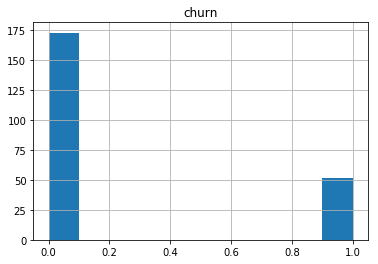

In [11]:
user_churn.toPandas().hist()

## 3.2 Explore Data

The "churn" target column is defined. Let's see relation between different columns/features and target column.

In [12]:
def independence_test(user_x, column_name):    
    churn_x = user_x.join(user_churn, "userId", "outer").persist()
    pivoted_x = churn_x.groupby("userId", "churn").pivot(column_name).count().fillna(0)
    ignore = ["userId", "churn"]
    assembler = VectorAssembler(
        inputCols=[x for x in pivoted_x.columns if x not in ignore],
        outputCol=f'{column_name}_features')
    pivoted_x_features = assembler.transform(pivoted_x)

    r = ChiSquareTest.test(pivoted_x_features, f'{column_name}_features', "churn").head()
    not_independent = np.sum([1 for v in r.pValues if v > 0.05])
    print(f"there are {not_independent} pValues greater than 0.05 out of {len(r.pValues)}")

def independence_test_pivoted(user_x, target_name, ignore = ["userId", "churn"]):    
    assembler = VectorAssembler(
        inputCols=[x for x in user_x.columns if x not in ignore],
        outputCol=f'{target_name}_features')
    pivoted_x_features = assembler.transform(user_x)

    r = ChiSquareTest.test(pivoted_x_features, f'{column_name}_features', "churn").head()
    not_independent = np.sum([1 for v in r.pValues if v > 0.05])
    print(f"there are {not_independent} pValues greater than 0.05 out of {len(r.pValues)}")

def spearman_heatmap(frame):
    corr = frame.corr(method="spearman")
    corr = corr.loc[["churn"],:]
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, linewidths=.5, cbar_kws={"shrink": .5})

### 3.2.1 Making features that could explain churn

I am going to explore the following features and verify that they have relation to response variable:
- location city
- location state
- user OS
- page view counts
- gender
- average user session with service per week
- items in session statistics
- length of listened songs

### 3.2.2 Location City and State

In [13]:

user_location = df.select("userId", "location").distinct()
split_col = split(user_location['location'], ',')
user_city = user_location.withColumn('location_city', split_col.getItem(0)).select("userId", "location_city").distinct()
user_city = user_city.withColumn("location_city", F.regexp_replace('location_city', '[\.\s]', '-')).persist()
user_state = user_location.withColumn('location_state', split_col.getItem(1)).select("userId", "location_state").distinct().persist()

In [14]:
user_city.toPandas().head()

,userId,location_city
0,19,Dayton
1,65,Concord
2,300011,New-York-Newark-Jersey-City
3,133,San-Diego-Carlsbad
4,2,Raleigh


In [15]:
user_state.toPandas().head()

,userId,location_state
0,43,MA-NH
1,111,MI
2,200007,NY-NJ-PA
3,300001,CO
4,100007,AR


In [16]:
churn_states = user_state.join(user_churn, "userId", "outer").persist()
churn_cities = user_city.join(user_churn, "userId", "outer").persist()

In [17]:
independence_test(user_state, "location_state")

there are 57 pValues greater than 0.05 out of 58


Lots of states may explain churn since they have pvalues greater than 0.05 meaning that null hypothesis that they are independent is rejected

In [18]:
independence_test(user_city, "location_city")

there are 110 pValues greater than 0.05 out of 113


The same situation is with cities. I will leave them as features

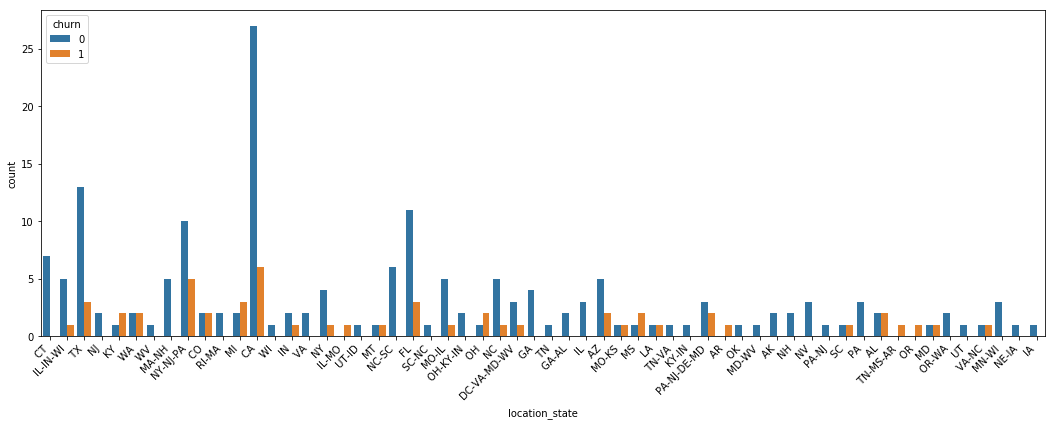

In [19]:
plt.figure(figsize=(18, 6))
plt.xticks(rotation=45, ha='right')
sns.countplot(x="location_state", hue="churn", data=churn_states.select("churn", "location_state").toPandas()) 

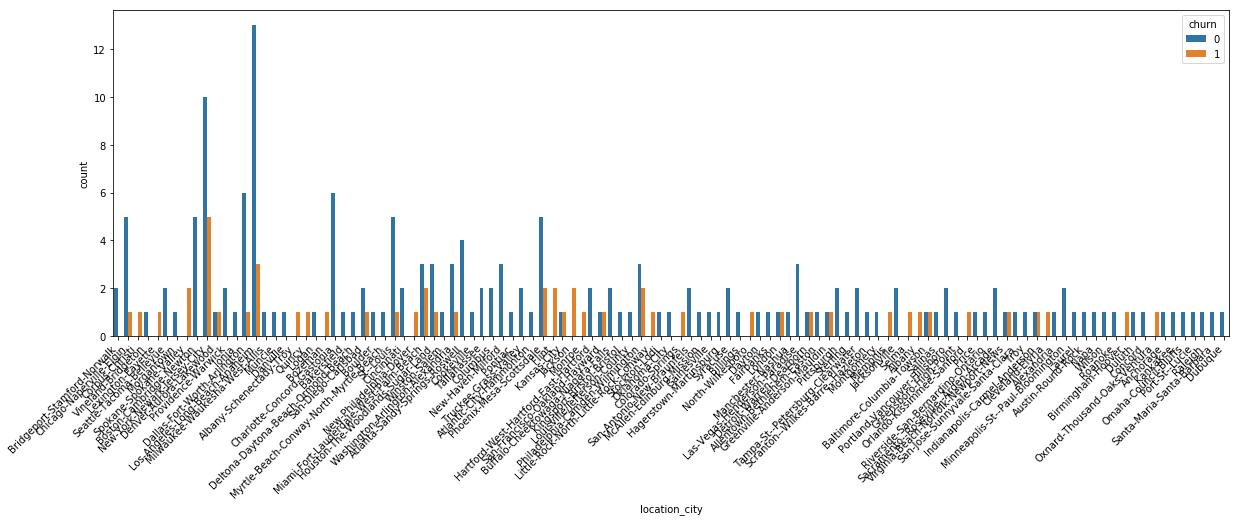

In [20]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=45, ha='right')
sns.countplot(x="location_city", hue="churn", data=churn_cities.select("churn", "location_city").toPandas()) 

### 3.2.3 User Operation System

In [21]:
user_agent = df.select("userId", "userAgent").distinct()
# Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0)
user_os = user_agent.withColumn("user_os", regexp_extract(col('userAgent'), r'Mozilla/5.0 \(([\w\s\.\/]*);', 1))
user_os = user_os.select("userId", "user_os")
user_os = user_os.withColumn("user_os", F.regexp_replace('user_os', '[\.\s]', '-'))
user_os = user_os.withColumn('user_os', when(col('user_os') != '', col('user_os')).otherwise("Unknown")).persist()

In [22]:
independence_test(user_os, "user_os")

there are 10 pValues greater than 0.05 out of 10


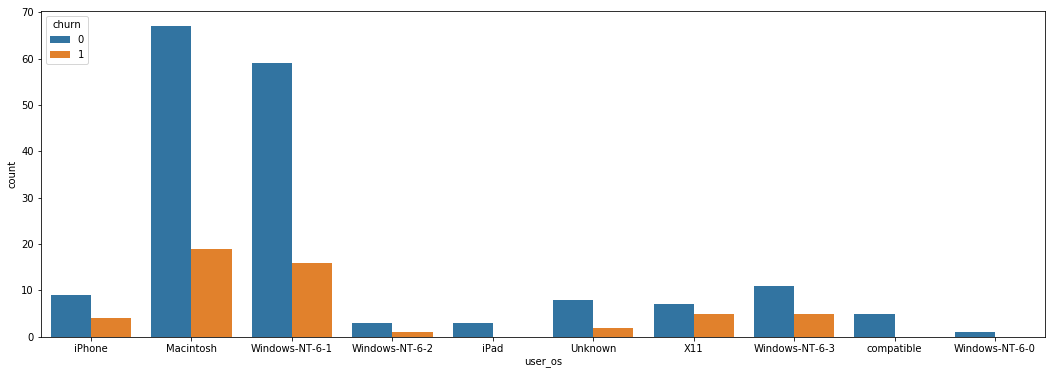

In [23]:
plt.figure(figsize=(18, 6))
churn_user_os = user_os.join(user_churn, "userId", "outer").persist()
sns.countplot(x="user_os", hue="churn", data=churn_user_os.select("churn", "user_os").toPandas()) 

From the plot above follows that user_os has some correlation with churn. I include this feature in the final dataset.

### 3.2.6 Page views (min, max, avg)

In [24]:
pages_to_drop = ['Cancel', 'Cancellation Confirmation', 'Downgrade', 'Submit Downgrade', 'Submit Upgrade', 'Upgrade']

page_view_pivot = \
    df.select("userId", "page", "day") \
      .groupby("userId", "day") \
      .pivot("page")
page_view_counts = page_view_pivot.count().drop(*pages_to_drop).fillna(0)
page_view_count_avg_per_day = page_view_counts.groupby("userId").avg()
page_view_count_min_per_day = page_view_counts.groupby("userId").min()
page_view_count_max_per_day = page_view_counts.groupby("userId").max()

In [25]:
page_view_count_avg_per_day.toPandas().head()

,userId,avg(About),avg(Add Friend),avg(Add to Playlist),avg(Error),avg(Help),avg(Home),avg(Logout),avg(NextSong),avg(Roll Advert),avg(Save Settings),avg(Settings),avg(Thumbs Down),avg(Thumbs Up)
0,100010,0.142857,0.571429,1.000000,0.000000,0.285714,1.571429,0.714286,39.285714,7.428571,0.000000,0.000000,0.714286,2.428571
1,200002,0.428571,0.571429,1.142857,0.000000,0.285714,2.857143,0.714286,55.285714,1.000000,0.000000,0.428571,0.857143,3.000000
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3,124,0.212121,2.242424,3.575758,0.181818,0.696970,5.333333,1.787879,123.606061,0.121212,0.181818,0.606061,1.242424,5.181818
4,51,0.153846,2.153846,4.000000,0.076923,0.923077,5.769231,1.846154,162.384615,0.000000,0.076923,0.923077,1.615385,7.692308


In [26]:
pd_page_view_count_avg_per_day = page_view_count_avg_per_day.join(user_churn, "userId", "outer").toPandas()
pd_page_view_count_min_per_day = page_view_count_min_per_day.join(user_churn, "userId", "outer").toPandas()
pd_page_view_count_max_per_day = page_view_count_max_per_day.join(user_churn, "userId", "outer").toPandas()

Correlation between page views and churn

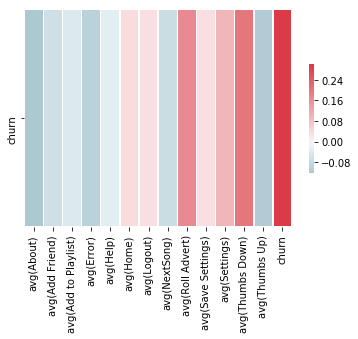

In [27]:
spearman_heatmap(pd_page_view_count_avg_per_day)

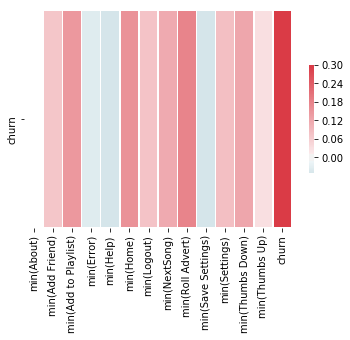

In [28]:
spearman_heatmap(pd_page_view_count_min_per_day)

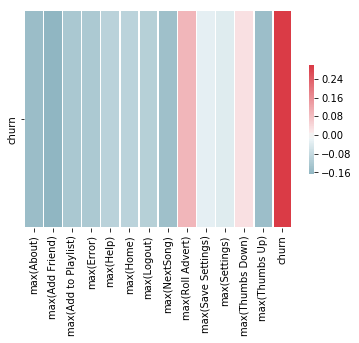

In [29]:
spearman_heatmap(pd_page_view_count_max_per_day)

It looks like pageviews per day for some of the pages have low-medium correlation with churn. I am including min/max/avg metrics for some of the pages to the final dataset.

### 3.2.7 Gender

In [39]:
user_gender = df.select("userId", "gender").distinct().persist()
pd_user_gender = user_gender.join(user_churn, "userId", "outer").toPandas()

In [40]:
pd_user_gender.groupby(["churn", "gender"]).count()

userId
churn gender        
0     F           84
      M           89
1     F           20
      M           32

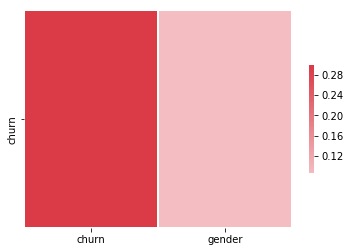

In [47]:
spearman_heatmap(pd_user_gender[["churn", "gender"]].apply(lambda x: x.factorize()[0]))

It looks like gender has very low correlation with churn therefore I am not adding it to the final dataset

### 3.2.8 User session stats with service per week

In [48]:
sessions_per_week = \
    df.select("userId", "sessionId", "week")\
      .distinct() \
      .groupby("userId", "week") \
      .agg({'sessionId':'count'}) \
      .groupby("userId") \
      .agg(F.min('count(sessionId)'), F.max('count(sessionId)'), F.avg('count(sessionId)')).persist()

In [49]:
pd_sessions_per_week = sessions_per_week.join(user_churn, "userId", "outer").toPandas()

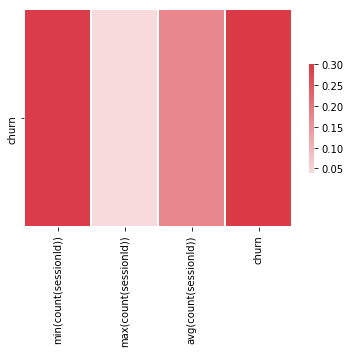

In [50]:
spearman_heatmap(pd_sessions_per_week)

Min and avg sessions per week has low-medium correlation with churn and will be added to the final dataset.

### 3.2.9 Length

In [51]:
user_length = df.select("userId", "length").groupby("userId").agg({"length":"sum"})

In [52]:
pd_user_length = user_length.join(user_churn, "userId", "outer").toPandas()

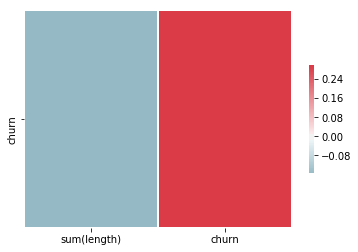

In [53]:
spearman_heatmap(pd_user_length)

The total length of all listened songs will be added to the final dataset.

### 3.2.10 Time Since Registration

In [54]:
time_since_registration = \
    spark.sql('''
        SELECT userId, (MAX(ts) - AVG(registration)) / 1000 as active_time
        FROM mini_sparkify_event_data
        GROUP BY userId
    ''')

In [55]:
pd_time_since_registration = time_since_registration.join(user_churn, "userId", "outer").toPandas()

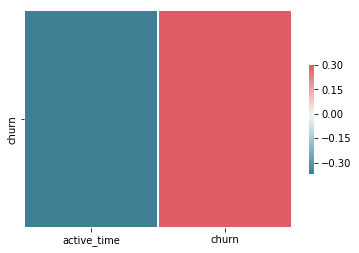

In [56]:
spearman_heatmap(pd_time_since_registration)

The time since registration has medium correlation with the churn.

### 3.2.10 Items in session

In [57]:
items_in_session = \
    df.select("userId", "itemInSession")\
      .groupby("userId") \
      .agg(F.min('itemInSession'), F.max('itemInSession'), F.avg('itemInSession')).persist()

In [58]:
pd_items_in_session = items_in_session.join(user_churn, "userId", "outer").toPandas()

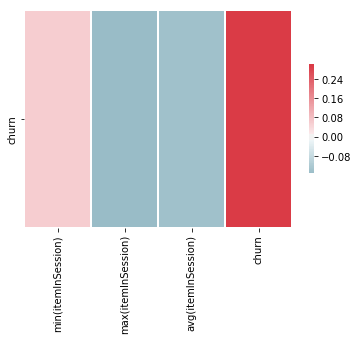

In [59]:
spearman_heatmap(pd_items_in_session)

Obviously the minimum and maximum item in session has positive and negative correlations and will be added to the final dataset.

# 4 Feature Engineering

# 4.1 Making dataset out of features 

I am taking the following features into the dataset:
- user_city
- user_state
- user_os
- page_view_count_per_day
  - Average for pageviews: About, Error, Next Song, Roll Advert, Thumbs Down, Thumbs Up
  - Minimum for pageviews: Add friend, Add to PLaylist, Next Song, Roll Advert, Thumbs Down, Thumbs Up
  - Maximum for pageviews: About, Add friend, Next Song, Thumbs Down
- items_in_session
  - min and max item in sessions
- sessions_per_week
  - minimum and average sessions per week
- user_length

In [60]:
clf_df = user_churn

In [61]:
# user_os
clf_df = clf_df.join(user_os, "userId", "outer" ).persist()

In [62]:
# pageview counts per day
page_view_count_avg_per_day = page_view_count_avg_per_day.select("userId", "avg(About)", "avg(Error)", "avg(NextSong)", "avg(Roll Advert)", "avg(Thumbs Down)", "avg(Thumbs Up)")
page_view_count_min_per_day = page_view_count_min_per_day.select("userId", "min(Add Friend)", "min(Add to Playlist)", "min(NextSong)", "min(Roll Advert)", "min(Thumbs Down)", "min(Thumbs Up)")
page_view_count_max_per_day = page_view_count_max_per_day.select("userId", "max(About)", "max(Add Friend)", "max(Add to Playlist)", "max(NextSong)", "max(Roll Advert)", "max(Thumbs Down)")


In [63]:
clf_df = clf_df.join(page_view_count_avg_per_day, "userId", "outer" ).persist()
clf_df = clf_df.join(page_view_count_min_per_day, "userId", "outer" ).persist()
clf_df = clf_df.join(page_view_count_max_per_day, "userId", "outer" ).persist()

In [64]:
items_in_session = items_in_session.select("userId", "min(itemInSession)", "max(itemInSession)")

In [65]:
clf_df = clf_df.join(items_in_session, "userId", "outer").persist()

In [66]:
sessions_per_week = sessions_per_week.select("userId", "min(count(sessionId))", "max(count(sessionId))", "avg(count(sessionId))")

In [67]:
clf_df = clf_df.join(sessions_per_week, "userId", "outer").persist()

In [68]:
# user_state
clf_df = clf_df.join(user_state, "userId", "outer" ).persist()

In [69]:
# user_city
clf_df = clf_df.join(user_city, "userId", "outer" ).persist()

In [70]:
# user_length
clf_df = clf_df.join(user_length, "userId", "outer" ).persist()

In [71]:
clf_df = clf_df.join(time_since_registration, "userId", "outer" ).persist()

In [72]:
clf_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- user_os: string (nullable = true)
 |-- avg(About): double (nullable = true)
 |-- avg(Error): double (nullable = true)
 |-- avg(NextSong): double (nullable = true)
 |-- avg(Roll Advert): double (nullable = true)
 |-- avg(Thumbs Down): double (nullable = true)
 |-- avg(Thumbs Up): double (nullable = true)
 |-- min(Add Friend): long (nullable = true)
 |-- min(Add to Playlist): long (nullable = true)
 |-- min(NextSong): long (nullable = true)
 |-- min(Roll Advert): long (nullable = true)
 |-- min(Thumbs Down): long (nullable = true)
 |-- min(Thumbs Up): long (nullable = true)
 |-- max(About): long (nullable = true)
 |-- max(Add Friend): long (nullable = true)
 |-- max(Add to Playlist): long (nullable = true)
 |-- max(NextSong): long (nullable = true)
 |-- max(Roll Advert): long (nullable = true)
 |-- max(Thumbs Down): long (nullable = true)
 |-- min(itemInSession): long (nullable = true)
 |-- max(itemInSessi

In [73]:
dataset = clf_df.drop("userId").fillna(0).persist()

In [74]:
mapping_list = [['churn', 'churn'], 
                   ['user_os', 'user_os'],
                   ['location_state', 'location_state'],
                   ['location_city', 'location_city'],
                   ['sum(length)', 'length_sum'],
                   ['avg(About)', 'page_view_about_avg'],
                   ['avg(Error)', 'page_view_error_avg'],
                   ['avg(NextSong)', 'page_view_next_song_avg'],
                   ['avg(Roll Advert)', 'page_view_roll_advert_avg'],
                   ['avg(Thumbs Down)', 'page_view_thumbs_down_avg'],
                   ['avg(Thumbs Up)', 'page_view_thumbs_up_avg'],
                   ['min(Add Friend)', 'page_view_add_friend_min'],
                   ['min(Add to Playlist)', 'page_view_add_to_playlist_min'],
                   ['min(NextSong)', 'page_view_next_song_min'],
                   ['min(Roll Advert)', 'page_view_roll_advert_min'],
                   ['min(Thumbs Down)', 'page_view_thumbs_down_min'],
                   ['min(Thumbs Up)', 'page_view_thumbs_up_min'],
                   ['max(About)', 'page_view_about_max'],
                   ['max(Add Friend)', 'page_view_add_friend_max'],
                   ['max(Add to Playlist)', 'page_view_add_to_playlist_max'],
                   ['max(NextSong)', 'page_view_next_song_max'],
                   ['max(Roll Advert)', 'page_view_roll_advert_max'],
                   ['max(Thumbs Down)', 'page_view_thumbs_down_max'],
                   ['min(itemInSession)', 'item_in_session_min'],
                   ['max(itemInSession)', 'item_in_session_max'],
                   ['min(count(sessionId))', 'session_count_min'],
                   ['avg(count(sessionId))', 'session_count_avg'],
                   ['max(count(sessionId))', 'session_count_max']]
mapping = {m[0]:m[1] for m in mapping_list}
dataset = dataset.select([F.col(c).alias(mapping.get(c, c)) for c in dataset.columns])

In [75]:
dataset.createOrReplaceTempView("input_dataset")

In [76]:
dataset.printSchema()

root
 |-- churn: long (nullable = true)
 |-- user_os: string (nullable = true)
 |-- page_view_about_avg: double (nullable = false)
 |-- page_view_error_avg: double (nullable = false)
 |-- page_view_next_song_avg: double (nullable = false)
 |-- page_view_roll_advert_avg: double (nullable = false)
 |-- page_view_thumbs_down_avg: double (nullable = false)
 |-- page_view_thumbs_up_avg: double (nullable = false)
 |-- page_view_add_friend_min: long (nullable = true)
 |-- page_view_add_to_playlist_min: long (nullable = true)
 |-- page_view_next_song_min: long (nullable = true)
 |-- page_view_roll_advert_min: long (nullable = true)
 |-- page_view_thumbs_down_min: long (nullable = true)
 |-- page_view_thumbs_up_min: long (nullable = true)
 |-- page_view_about_max: long (nullable = true)
 |-- page_view_add_friend_max: long (nullable = true)
 |-- page_view_add_to_playlist_max: long (nullable = true)
 |-- page_view_next_song_max: long (nullable = true)
 |-- page_view_roll_advert_max: long (nullabl

In [77]:
pd_input_dataset = spark.sql("SELECT * FROM input_dataset LIMIT 10").toPandas().dropna()
pd_input_dataset

,churn,user_os,page_view_about_avg,page_view_error_avg,page_view_next_song_avg,page_view_roll_advert_avg,page_view_thumbs_down_avg,page_view_thumbs_up_avg,page_view_add_friend_min,page_view_add_to_playlist_min,...,page_view_thumbs_down_max,item_in_session_min,item_in_session_max,session_count_min,session_count_max,session_count_avg,location_state,location_city,length_sum,active_time
0,0,iPhone,0.142857,0.000000,39.285714,7.428571,0.714286,2.428571,0,0,...,2,0,111,1,2,1.166667,CT,Bridgeport-Stamford-Norwalk,6.694090e+04,4807612.0
1,0,iPhone,0.428571,0.000000,55.285714,1.000000,0.857143,3.000000,0,0,...,4,0,157,1,2,1.500000,IL-IN-WI,Chicago-Naperville-Elgin,9.400888e+04,6054448.0
2,1,Macintosh,0.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0,0,...,0,0,10,1,1,1.000000,TX,Corpus-Christi,2.089113e+03,6161779.0
3,0,Macintosh,0.212121,0.181818,123.606061,0.121212,1.242424,5.181818,0,0,...,9,0,530,1,5,2.900000,NJ,Vineland-Bridgeton,1.012312e+06,11366431.0
4,1,Windows-NT-6-1,0.153846,0.076923,162.384615,0.000000,1.615385,7.692308,0,0,...,3,0,619,1,6,3.666667,KY,Lexington-Fayette,5.232758e+05,1680985.0
5,0,Windows-NT-6-1,0.000000,0.125000,18.750000,2.000000,0.125000,0.875000,0,0,...,1,0,92,1,2,1.142857,WA,Seattle-Tacoma-Bellevue,3.803409e+04,6288035.0
6,0,Windows-NT-6-1,0.105263,0.105263,100.736842,0.052632,0.736842,4.263158,0,0,...,3,0,423,1,4,2.000000,WV,Morgantown,4.773076e+05,4882773.0
7,1,Windows-NT-6-1,0.161290,0.032258,91.645161,1.516129,0.935484,5.258065,0,0,...,3,0,581,2,8,5.714286,WA,Spokane-Spokane-Valley,7.113449e+05,9568946.0
8,0,Windows-NT-6-1,0.250000,0.375000,102.500000,1.000000,0.375000,7.250000,0,1,...,1,0,334,1,2,1.500000,MA-NH,Boston-Cambridge-Newton,1.987793e+05,2035240.0
9,1,Windows-NT-6-1,0.000000,0.000000,42.833333,0.333333,0.500000,2.833333,0,0,...,1,0,94,1,2,1.200000,NY-NJ-PA,New-York-Newark-Jersey-City,6.770347e+04,7351206.0


## 4.2 Inspecting feature distributions

I verify that the feature distributions have no scaling issues.

Feature Distributions.


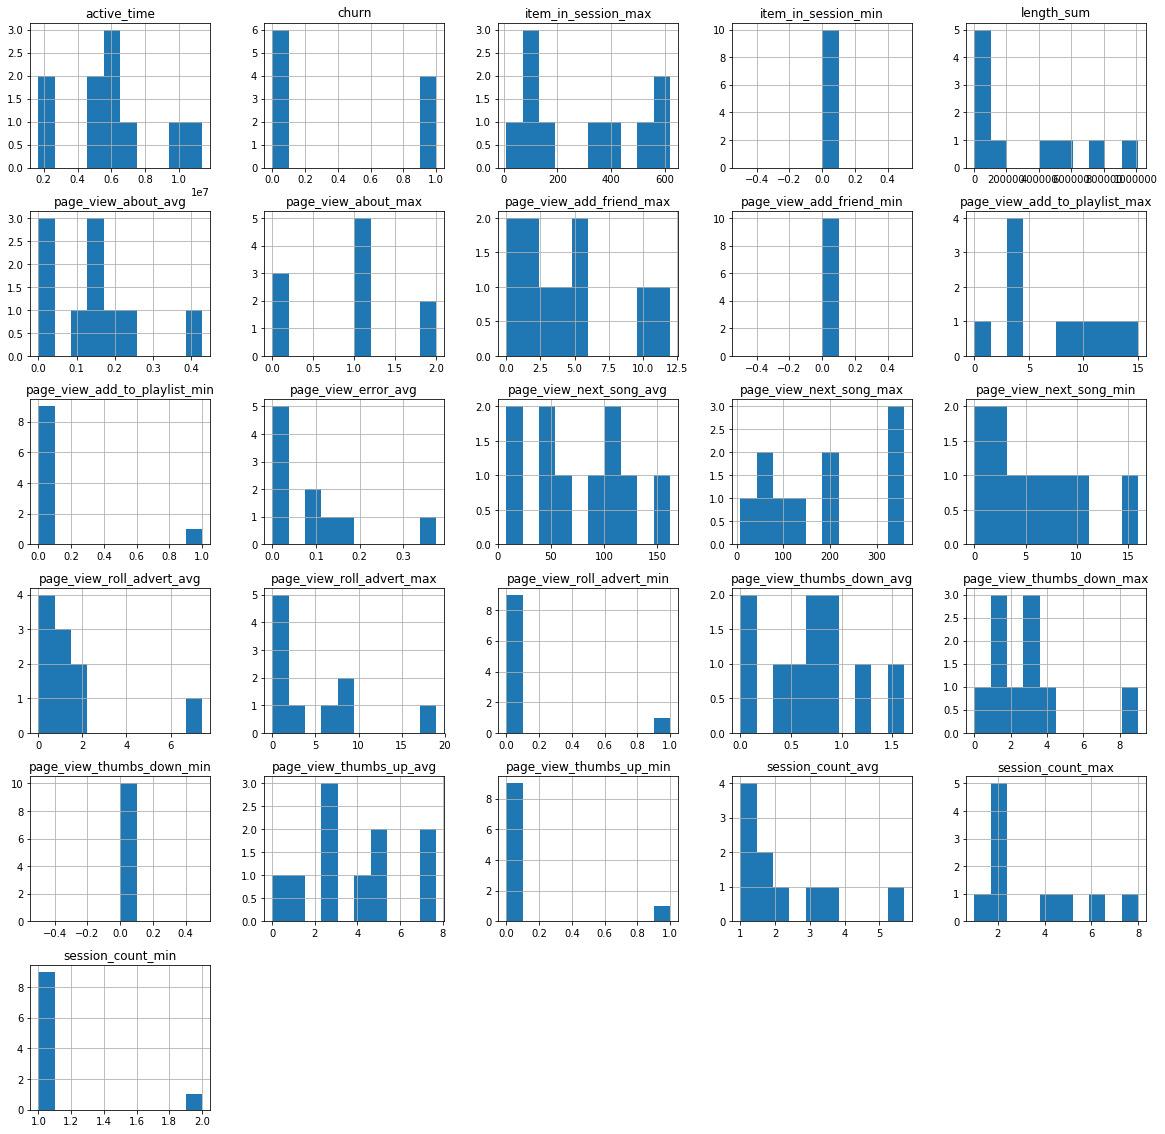

In [78]:
pd_input_dataset.hist(figsize=(20,20))
print("Feature Distributions.")

I apply log scale to `active_time` and `lengths_sum` as they seem to big.

In [79]:
dataset = dataset.withColumn("length_sum", F.log(dataset["length_sum"] + 1))
dataset = dataset.withColumn("active_time", F.log(dataset["active_time"] + 1))
dataset.createOrReplaceTempView("input_dataset")
pd_input_dataset = spark.sql("SELECT * FROM input_dataset LIMIT 10").toPandas().dropna()
pd_input_dataset

,churn,user_os,page_view_about_avg,page_view_error_avg,page_view_next_song_avg,page_view_roll_advert_avg,page_view_thumbs_down_avg,page_view_thumbs_up_avg,page_view_add_friend_min,page_view_add_to_playlist_min,...,page_view_thumbs_down_max,item_in_session_min,item_in_session_max,session_count_min,session_count_max,session_count_avg,location_state,location_city,length_sum,active_time
0,0,iPhone,0.142857,0.000000,39.285714,7.428571,0.714286,2.428571,0,0,...,2,0,111,1,2,1.166667,CT,Bridgeport-Stamford-Norwalk,11.111580,15.385711
1,0,iPhone,0.428571,0.000000,55.285714,1.000000,0.857143,3.000000,0,0,...,4,0,157,1,2,1.500000,IL-IN-WI,Chicago-Naperville-Elgin,11.451155,15.616304
2,1,Macintosh,0.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0,0,...,0,0,10,1,1,1.000000,TX,Corpus-Christi,7.644973,15.633876
3,0,Macintosh,0.212121,0.181818,123.606061,0.121212,1.242424,5.181818,0,0,...,9,0,530,1,5,2.900000,NJ,Vineland-Bridgeton,13.827748,16.246175
4,1,Windows-NT-6-1,0.153846,0.076923,162.384615,0.000000,1.615385,7.692308,0,0,...,3,0,619,1,6,3.666667,KY,Lexington-Fayette,13.167866,14.334891
5,0,Windows-NT-6-1,0.000000,0.125000,18.750000,2.000000,0.125000,0.875000,0,0,...,1,0,92,1,2,1.142857,WA,Seattle-Tacoma-Bellevue,10.546264,15.654159
6,0,Windows-NT-6-1,0.105263,0.105263,100.736842,0.052632,0.736842,4.263158,0,0,...,3,0,423,1,4,2.000000,WV,Morgantown,13.075919,15.401224
7,1,Windows-NT-6-1,0.161290,0.032258,91.645161,1.516129,0.935484,5.258065,0,0,...,3,0,581,2,8,5.714286,WA,Spokane-Spokane-Valley,13.474914,16.074034
8,0,Windows-NT-6-1,0.250000,0.375000,102.500000,1.000000,0.375000,7.250000,0,1,...,1,0,334,1,2,1.500000,MA-NH,Boston-Cambridge-Newton,12.199955,14.526125
9,1,Windows-NT-6-1,0.000000,0.000000,42.833333,0.333333,0.500000,2.833333,0,0,...,1,0,94,1,2,1.200000,NY-NJ-PA,New-York-Newark-Jersey-City,11.122908,15.810375


Feature Distributions.


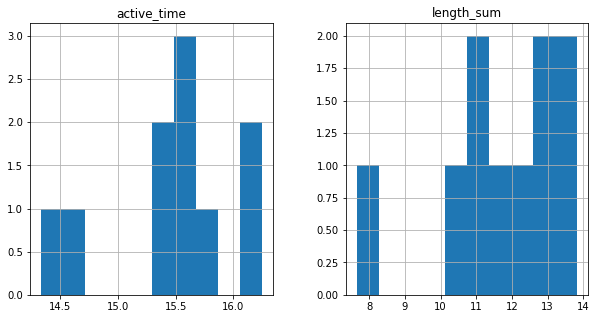

In [80]:
pd_input_dataset[["active_time", "length_sum"]].hist(figsize=(10,5))
print("Feature Distributions.")

## 4.3 Saving intermediate dataset

In [81]:
dataset.toPandas().dropna().to_csv("./backup.csv", index=False)

In [82]:
backup = pd.read_csv("./backup.csv")
sql_ctx = SQLContext(spark)
dataset = sql_ctx.createDataFrame(backup)

# 5 Modeling

I split the dataset into train, validation sets for model selection.

In [83]:
def evaluate_and_get_f1score(context, cv_model, data):
    results = cv_model.transform(data)
    prediction_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    print(f"  evaluation on '{context}'...")
    f1score = prediction_evaluator.evaluate(results, {prediction_evaluator.metricName: "f1"})
    print("  precision", prediction_evaluator.evaluate(results, {prediction_evaluator.metricName: "weightedPrecision"}))
    print("  recall", prediction_evaluator.evaluate(results, {prediction_evaluator.metricName: "weightedRecall"}))
    print("  accuracy", prediction_evaluator.evaluate(results, {prediction_evaluator.metricName: "accuracy"}))
    print("  f1score", f1score)
    print("---------")
    return f1score

def model_selection_metrics(classifier_factory, train_set, validation_set):
    num_folds = 3
    f1scores = []
    for i in range(10, 15):
        seed = np.power(2, i)
        print("with new seed:")
        multi_class_evaluator = MulticlassClassificationEvaluator(metricName='f1')
        param_grid = ParamGridBuilder().build()
        cv = CrossValidator(estimator=classifier_factory(seed), evaluator=multi_class_evaluator, estimatorParamMaps=param_grid, numFolds=num_folds)
        print("  training...")
        cv_model = cv.fit(train_set)
        evaluate_and_get_f1score("training", cv_model, train_set)
        f1score = evaluate_and_get_f1score("validation", cv_model, validation_set)
        f1scores.append(f1score)
    print("avg f1: ", np.mean(f1scores))

## 5.1 Assembling the features

The features from the final dataset will be assembled into vectorized form for further model selection.

In [84]:
numeric_columns = [
"page_view_about_avg", 
"page_view_error_avg",
"page_view_next_song_avg",
"page_view_roll_advert_avg",
"page_view_thumbs_down_avg",
"page_view_thumbs_up_avg",
"page_view_add_friend_min",
"page_view_add_to_playlist_min",
"page_view_next_song_min",
"page_view_roll_advert_min",
"page_view_thumbs_down_min",
"page_view_thumbs_up_min",
"page_view_about_max",
"page_view_add_friend_max",
"page_view_add_to_playlist_max",
"page_view_next_song_max",
"page_view_roll_advert_max",
"page_view_thumbs_down_max",
"item_in_session_min",
"item_in_session_max",
"length_sum",
"session_count_min",
"active_time"]

assembler = VectorAssembler(inputCols = numeric_columns, outputCol = 'numeric_features')
dataset = assembler.transform(dataset)
scaler = StandardScaler(inputCol='numeric_features', outputCol='scaled_features', withStd=True)
scale_model = scaler.fit(dataset)
dataset = scale_model.transform(dataset)

features_df = dataset

In [85]:
features_df.take(1)

[Row(churn=0, user_os='iPhone', page_view_about_avg=0.14285714285714285, page_view_error_avg=0.0, page_view_next_song_avg=39.285714285714285, page_view_roll_advert_avg=7.428571428571429, page_view_thumbs_down_avg=0.7142857142857143, page_view_thumbs_up_avg=2.4285714285714284, page_view_add_friend_min=0, page_view_add_to_playlist_min=0, page_view_next_song_min=7, page_view_roll_advert_min=0, page_view_thumbs_down_min=0, page_view_thumbs_up_min=0, page_view_about_max=1, page_view_add_friend_max=2, page_view_add_to_playlist_max=3, page_view_next_song_max=80, page_view_roll_advert_max=19, page_view_thumbs_down_max=2, item_in_session_min=0, item_in_session_max=111, session_count_min=1, session_count_max=2, session_count_avg=1.1666666666666667, location_state=' CT', location_city='Bridgeport-Stamford-Norwalk', length_sum=11.111580318403073, active_time=15.385711261109032, numeric_features=DenseVector([0.1429, 0.0, 39.2857, 7.4286, 0.7143, 2.4286, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 

In [86]:
churn_dataset = features_df.select(col('scaled_features').alias('features'), 
                                   col('churn').alias('label')).persist()

In [87]:
train, valid = churn_dataset.randomSplit([0.8, 0.2], seed=42)
train = train.persist()
valid = valid.persist()

## 5.2 Model selection

I am planning to do model selection with different seeds to be sure that the model is stable.

In [88]:
def decision_tree_factory(seed):
    return DecisionTreeClassifier(seed = seed)
model_selection_metrics(decision_tree_factory, train, valid)

with new seed:
  training...
  evaluation on 'training'...
  precision 0.9332194693601702
  recall 0.9326424870466321
  accuracy 0.9326424870466321
  f1score 0.9328984179954586
---------
  evaluation on 'validation'...
  precision 0.8062770562770563
  recall 0.75
  accuracy 0.75
  f1score 0.7669082125603864
---------
with new seed:
  training...
  evaluation on 'training'...
  precision 0.9332194693601702
  recall 0.9326424870466321
  accuracy 0.9326424870466321
  f1score 0.9328984179954586
---------
  evaluation on 'validation'...
  precision 0.8062770562770563
  recall 0.75
  accuracy 0.75
  f1score 0.7669082125603864
---------
with new seed:
  training...
  evaluation on 'training'...
  precision 0.9332194693601702
  recall 0.9326424870466321
  accuracy 0.9326424870466321
  f1score 0.9328984179954586
---------
  evaluation on 'validation'...
  precision 0.8062770562770563
  recall 0.75
  accuracy 0.75
  f1score 0.7669082125603864
---------
with new seed:
  training...
  evaluation o

In [89]:
def random_forest_factory(seed):
    return RandomForestClassifier(seed=seed)
model_selection_metrics(random_forest_factory, train, valid)

with new seed:
  training...
  evaluation on 'training'...
  precision 0.9424870466321245
  recall 0.9378238341968912
  accuracy 0.9378238341968912
  f1score 0.9342522762211881
---------
  evaluation on 'validation'...
  precision 0.8337053571428571
  recall 0.84375
  accuracy 0.84375
  f1score 0.8268653516295024
---------
with new seed:
  training...
  evaluation on 'training'...
  precision 0.9469482191155865
  recall 0.9430051813471502
  accuracy 0.9430051813471503
  f1score 0.9400582674564697
---------
  evaluation on 'validation'...
  precision 0.8337053571428571
  recall 0.84375
  accuracy 0.84375
  f1score 0.8268653516295024
---------
with new seed:
  training...
  evaluation on 'training'...
  precision 0.9294319590578213
  recall 0.9222797927461139
  accuracy 0.9222797927461139
  f1score 0.9163820535461406
---------
  evaluation on 'validation'...
  precision 0.8922413793103448
  recall 0.875
  accuracy 0.875
  f1score 0.8546296296296296
---------
with new seed:
  training...


In [90]:
def gbt_factory(seed):
    return GBTClassifier(seed = seed)
model_selection_metrics(gbt_factory, train, valid)

with new seed:
  training...
  evaluation on 'training'...
  precision 1.0
  recall 1.0
  accuracy 1.0
  f1score 1.0
---------
  evaluation on 'validation'...
  precision 0.7831477732793523
  recall 0.6875
  accuracy 0.6875
  f1score 0.7130681818181818
---------
with new seed:
  training...
  evaluation on 'training'...
  precision 1.0
  recall 1.0
  accuracy 1.0
  f1score 1.0
---------
  evaluation on 'validation'...
  precision 0.7831477732793523
  recall 0.6875
  accuracy 0.6875
  f1score 0.7130681818181818
---------
with new seed:
  training...
  evaluation on 'training'...
  precision 1.0
  recall 1.0
  accuracy 1.0
  f1score 1.0
---------
  evaluation on 'validation'...
  precision 0.7831477732793523
  recall 0.6875
  accuracy 0.6875
  f1score 0.7130681818181818
---------
with new seed:
  training...
  evaluation on 'training'...
  precision 1.0
  recall 1.0
  accuracy 1.0
  f1score 1.0
---------
  evaluation on 'validation'...
  precision 0.7831477732793523
  recall 0.6875
  acc

The test results are the following:

| Classifier        | f1score       |
|-------------------|---------------|
| Decision Tree     | 0.76690821256 |
| Random Forest     | 0.82          |
| Gradient Boosting | 0.71          |

The best model is RandomForestClassifier with f1score 0.82. Not surprisingly gradient boosting classifier has overfitted showing 1.0 on the training set.

## 5.3 Tuning the best model

In [91]:
num_folds = 3
model = RandomForestClassifier()
multi_class_evaluator = MulticlassClassificationEvaluator(metricName='f1')
param_grid = ParamGridBuilder()\
    .addGrid(model.maxDepth, [1, 2, 3, 5])\
    .addGrid(model.numTrees,[1, 5, 10, 15, 20, 25, 30, 40])\
    .build()

cv = CrossValidator(estimator=model, evaluator=multi_class_evaluator, estimatorParamMaps=param_grid, numFolds=num_folds)
print("training...")
cv_model = cv.fit(train)
evaluate_and_get_f1score("training", cv_model, train)
evaluate_and_get_f1score("validation", cv_model, valid)


training...
  evaluation on 'training'...
  precision 0.874359649893153
  recall 0.849740932642487
  accuracy 0.8497409326424871
  f1score 0.8207274794346908
---------
  evaluation on 'validation'...
  precision 0.8369391025641024
  recall 0.84375
  accuracy 0.84375
  f1score 0.8392722473604827
---------


0.8392722473604827

## 5.4 The best model parameters

In [92]:
best_model = cv_model.bestModel
bestParams = best_model.extractParamMap()

In [93]:
for param, value in bestParams.items():
    print(f"{param.name}: {value}")

cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: gini
labelCol: label
maxBins: 32
maxDepth: 3
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
numTrees: 10
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -3537354893188193752
subsamplingRate: 1.0


## 5.4 Feature Importance

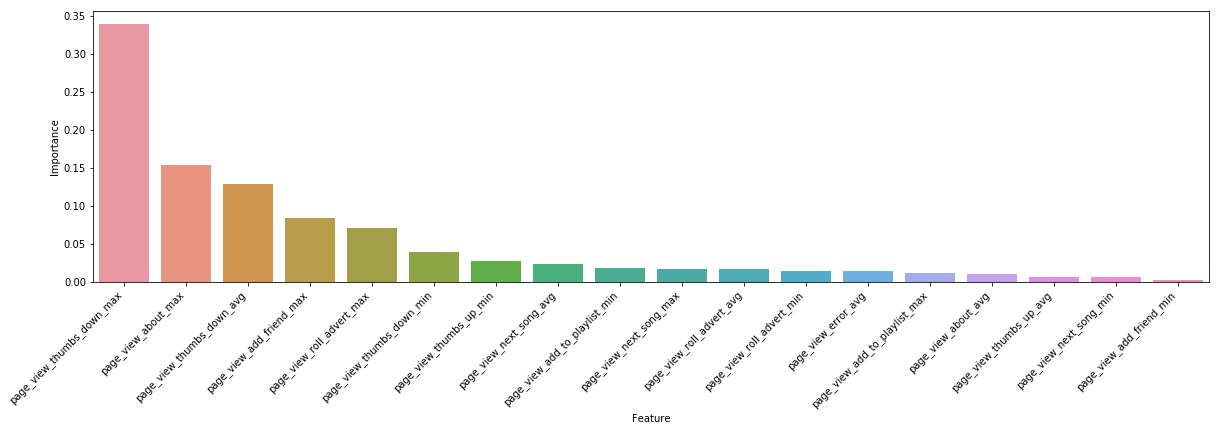

In [94]:
features_importance_list = list(zip(assembler.getInputCols(), best_model.featureImportances.values))

feature_importance = \
    pd.DataFrame(features_importance_list, columns=['Feature', 'Importance']) \
      .sort_values('Importance', ascending=False)
plt.figure(figsize=(20,5))
plt.xticks(rotation=45, ha='right')
sns.barplot(x='Feature', y='Importance', data=feature_importance)


## 5.5 Evaluation on the full dataset

Evaluation on the full dataset is done using AWS EMR Spark cluster and therefore is available in the follow up notebook "Sparkify_churn_full" in the same directory...

# 6 Conclusions and Future Work

In this article I considered the problem of churn classification. The volume of the data did not allow to operate on the full dataset effectively therefore the pipeline has been split into two steps: model selection and model tuning.

The model selection has been performed on the small subset of data using three candidates: DecisionTree, Random Forest and Gradient Boosting. The best selected model is Random Forest Classifier with the f1score 0.82.

The model tuning has been performed on the full dataset using AWS spark cluster with the best model from the model selection process. The test score on the full dataset is  0.81.

It is interesting and in some sense expected that the Gradient Boosting Tree model has overfit on the small subset of data where it reports f1score 1.0 on the training set and 0.71 on the evaluation set. It seems that there are some parameters are set to subnormal values by default therefore I am seeing a lots of improvements here. Some of them are given below:
- Use grid parameter selection for this classifier despite it performed not very well on the evaluation set with focus on max tree depth parameter
- Reduce the number of features by checking which features are correlated
- Increase the number of training samples.
- Apply regularisation 

As expected the data preprocessing and feature engineering took the most of the time since it was required to conduct lots of experiments with feature candidates, therefore certain time and complexity tradeoffs has been made to limit the number of possible features leaving some of the feature not explored and therefore leaving some space for possible improvement. The features that could be further explored are:
- number of thumbs up/down per songs listened per time interval
- number of roll advert per songs listened per time interval
- average number of songs listened per day
- decrease in service interactions over time
- decrease in number of songs listened over time

In this work certain prediction quality has been achieved on three model types, and it will be beneficial to evaluate other model types available in spark, such as SVM and Logistic Regression, to confirm that the current model is top performer.

Also as part of future work the pipelines can be productionalized to an application that could perform two tasks: 
- periodic assessment of customers and generate report with the customers under risk
- periodic model selection process where the model type and parameters can be automatically selected based on input data. This pipeline could ensure that model performance does not degrade with the time.